# Previsão da velocidade do vento a curto prazo usando redes neurais artificiais em Mucuri, Bahia (versão com LSTM)

## Configuração

Inclusão dos imports necessários

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tabulate
import tensorflow as tf

from ai_utils import metrics
from datetime import datetime
from IPython.display import SVG, HTML, display
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras_lr_finder import LRFinder
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


## Leitura e normalização dos dados

Carregando dados do arquivo

In [2]:
_file = pd.ExcelFile("./Mucuri_novo_semNaN_torre150m.xlsx")
df = _file.parse("Dados anemo")

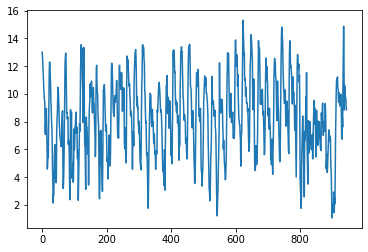

In [3]:
plt.plot(df.v_anemo2)
plt.show()

Separando dados de treino e de teste

In [4]:
train_data_1 = df[pd.to_datetime(df["Data"]) <= datetime(year=2015, month=12, day=22)]
train_data_2 = df[
    (pd.to_datetime(df["Data"]) == datetime(year=2015, month=12, day=23))
    & (df["hora"] <= 11)
]

X_train_data = pd.concat([train_data_1, train_data_2]).drop(["Data", "dia", "mês", "ano", "hora"], axis=1)

In [5]:
test_data_1 = df[
    (pd.to_datetime(df["Data"]) == datetime(year=2015, month=12, day=23))
    & (df["hora"] >= 12)
]
test_data_2 = df[
    (pd.to_datetime(df["Data"]) >= datetime(year=2015, month=12, day=24))
    & (pd.to_datetime(df["Data"]) <= datetime(year=2015, month=12, day=30))
]
test_data_3 = df[
    (pd.to_datetime(df["Data"]) == datetime(year=2015, month=12, day=31))
    & (df["hora"] <= 13)
]

X_test_data = pd.concat([test_data_1, test_data_2, test_data_3]).drop(["Data", "dia", "mês", "ano", "hora"], axis=1)

In [6]:
def generate_Y(X, number_of_hours=1):
    
    X = X.copy()
    
    try:
        Y = X.v_anemo2
    except:
        Y = X[:,0]

    Y = Y[number_of_hours:]
    X = X[:len(X)-number_of_hours]
    
    return X, Y

Normalizando com `minmax`

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_data = scaler.fit_transform(X_train_data)
X_test_data = scaler.fit_transform(X_test_data)

In [8]:
X_train, Y_train = generate_Y(X_train_data)

In [9]:
X_test, Y_test = generate_Y(X_test_data)

In [10]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, 5))
X_test = np.reshape(X_test, (X_test.shape[0], 1, 5))

## Definição do modelo

In [11]:
class MucuriModelLSTM:
    
    def __init__(self):
        
        self.model = None
        self._build_model()
        
    def _build_model(self):
        
        if self.model is None:
            
            self.model = Sequential()
            self.model.add(LSTM(4, input_shape=(1, 5)))
            self.model.add(Dense(1))
            self.model.compile(loss="mean_squared_error", optimizer=Adam(0.013), metrics=["mse", "mae"])
            
    def train(self, X, Y, X_test=None, Y_test=None, epochs=50, verbose=0):
        
        return self.model.fit(
            X,
            Y,
            validation_data=(X_test, Y_test) if X_test is not None and Y_test is not None else None,
            verbose=verbose,
            batch_size=64,
            epochs=epochs,
        )
    
    def predict(self, X):
        
        return self.model.predict(X)

In [12]:
model = MucuriModelLSTM()

Estimativa do valor ótimo de learning rate

In [13]:
%%capture

lr_finder = LRFinder(model.model)
lr_finder.find(X_train, Y_train, start_lr=0.01, end_lr=0.015, epochs=300)

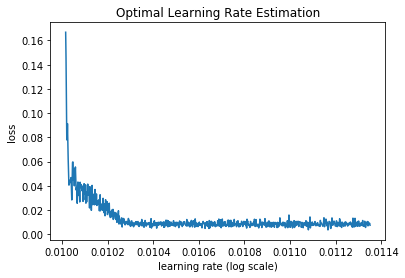

In [14]:
lr_finder.plot_loss()
plt.title(f"Optimal Learning Rate Estimation")
plt.xscale('linear')
plt.show()

## Treinamento

O processo de treino foi realizado ao longo de 100 épocas

In [15]:
training_history = model.train(X_train, Y_train, X_test, Y_test, epochs=100, verbose=0)

## Avaliação

### Gráficos do processo de treino

Plotagem das métricas do processo de treino

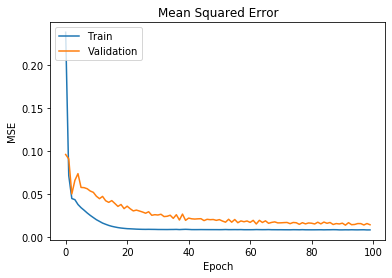

In [16]:
plt.plot(training_history.history["mse"])
plt.plot(training_history.history["val_mse"])
plt.title("Mean Squared Error")
plt.ylabel("MSE")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

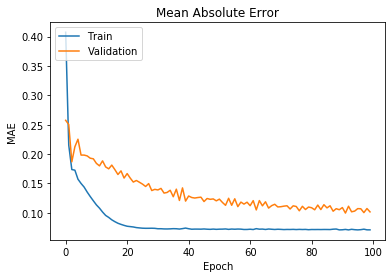

In [17]:
plt.plot(training_history.history["mae"])
plt.plot(training_history.history["val_mae"])
plt.title("Mean Absolute Error")
plt.ylabel("MAE")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

### Métricas

Inclusão das funções que calculam as métricas `Pearson R`, `R2` e `fac2`.

In [20]:
def pearson_r(y_true, y_pred):

    numpy_ = type(y_true).__name__ == 'ndarray'

    if numpy_:
        y_true_mean = y_true.mean()
        y_pred_mean = y_pred.mean()

        diff_yt = y_true - y_true_mean
        diff_yp = y_pred - y_pred_mean

        numerator = np.sum((diff_yt) * (diff_yp))
        denominator = np.sqrt(np.sum(np.square(diff_yt))) * np.sqrt(np.sum(np.square(diff_yp)))
    else:
        y_true_mean = K.mean(y_true)
        y_pred_mean = K.mean(y_pred)

        diff_yt = y_true - y_true_mean
        diff_yp = y_pred - y_pred_mean

        numerator = K.sum((diff_yt) * (diff_yp))
        denominator = K.sqrt(K.sum(K.square(diff_yt))) * K.sqrt(K.sum(K.square(diff_yp)))

    r = numerator / denominator

    return r

In [19]:
def R_squared(y_true, y_pred):
    
    numpy_ = type(y_true).__name__ == 'ndarray'

    if numpy_:
        y_true_mean = y_true.mean()
        y_pred_mean = y_pred.mean()

        sum_num = np.sum((y_pred-y_pred_mean)*y_true)
        numerator = np.square(sum_num)

        denominator = np.sum(np.square(y_pred - y_pred_mean)) * np.sum(np.square(y_true - y_true_mean))
    else:
        y_true_mean = K.mean(y_true)
        y_pred_mean = K.mean(y_pred)

        numerator = K.square(K.sum((y_pred-y_pred_mean) * y_true))
        denominator = K.sum(K.square(y_pred - y_pred_mean)) * K.sum(K.square(y_true - y_true_mean))

    R2 = numerator / denominator
    
    return R2

In [21]:
def fac2(y_true, y_pred, to_numpy=False):
    min_ = 0.5
    max_ = 2

    division = tf.math.divide_no_nan(y_pred, y_true)

    greater_min = tf.greater_equal(division, min_)
    less_max = tf.less_equal(division, max_)

    res = tf.equal(greater_min, less_max)
    res = tf.cast(res, tf.float32)

    fac_2 = tf.reduce_mean(res)

    return K.get_value(fac_2) if to_numpy else fac_2

### Predição

In [18]:
def predict(X, number_of_hours):
  
    assert number_of_hours > 0

    result = None
    input_data = X.copy()
    
    for hour in range(number_of_hours):
        
        predictions = np.array([model.predict([[value]])[0] for value in input_data])
        input_data = input_data[1:]
        
        # TODO: melhorar esse assign na coluna usando alguma função do numpy
        for line in range(len(input_data)):
            input_data[line][0][0] = predictions[line]

        result = predictions
        
    return result

Predição com base nos dados de treino

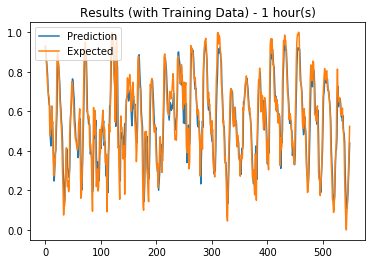

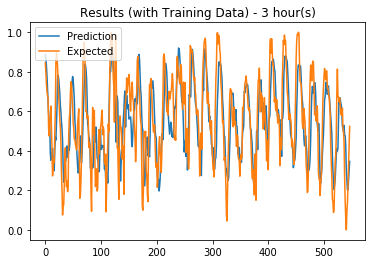

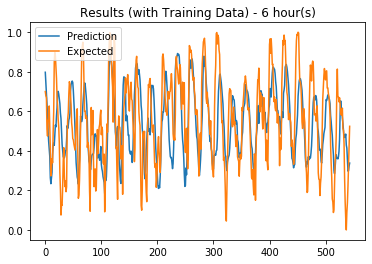

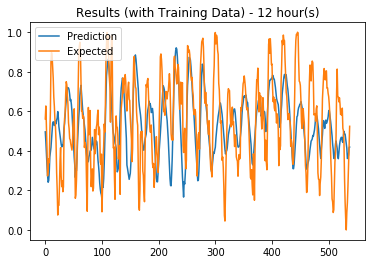

In [22]:
for hour in [1, 3, 6, 12]:
    prediction = predict(X_train, hour)
    _, expected_results = generate_Y(X_train_data, hour)
    
    if hour == 1:
        
        training_history.history["r_train"] = pearson_r(expected_results, prediction)
        training_history.history["r2_train"] = R_squared(expected_results, prediction)
        training_history.history["fac2_train"] = fac2(expected_results, prediction)
    
    plt.plot(prediction)
    plt.plot(expected_results)
    plt.title(f"Results (with Training Data) - {hour} hour(s)")
    plt.legend(["Prediction", "Expected"], loc="upper left")
    plt.show()

Predição com base nos dados de teste

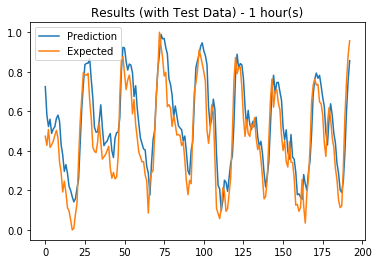

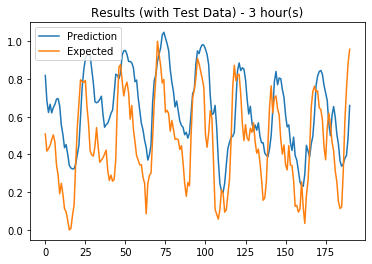

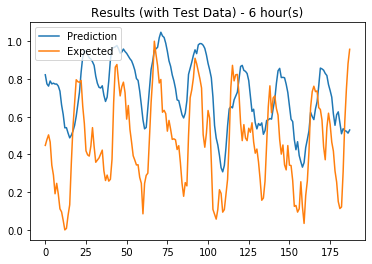

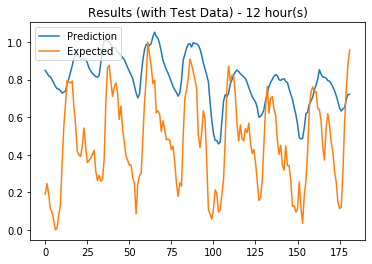

In [23]:
for hour in [1, 3, 6, 12]:
    prediction = predict(X_test, hour)
    _, expected_results = generate_Y(X_test_data, hour)
    
    if hour == 1:
        
        training_history.history["r_test"] = pearson_r(expected_results, prediction)
        training_history.history["r2_test"] = R_squared(expected_results, prediction)
        training_history.history["fac2_test"] = fac2(expected_results, prediction)
    
    plt.plot(prediction)
    plt.plot(expected_results)
    plt.title(f"Results (with Test Data) - {hour} hour(s)")
    plt.legend(["Prediction", "Expected"], loc="upper left")
    plt.show()

Tabela com os melhores valores obtidos das métricas durante o processo de treino

In [24]:
table = [
    ["Metric",],
    ["MSE training",],
    ["MSE validation",],
    ["MAE training",],
    ["MAE validation",],
    ["R training",],
    ["R test",],
    ["R2 training",],
    ["R2 test",],
    ["fac2 training",],
    ["fac2 test",],
]
    
table[0].append("Value")
table[1].append(min(training_history.history['mse']))
table[2].append(min(training_history.history['val_mse']))
table[3].append(min(training_history.history['mae']))
table[4].append(min(training_history.history['val_mae']))
table[5].append(training_history.history['r_train'])
table[6].append(training_history.history['r_test'])
table[7].append(training_history.history['r2_train'])
table[8].append(training_history.history['r2_test'])
table[9].append(training_history.history['fac2_train'])
table[10].append(training_history.history['fac2_test'])
    
display(HTML(tabulate.tabulate(table, tablefmt="html", headers="firstrow")))

Metric,Value
MSE training,0.0081677
MSE validation,0.0137297
MAE training,0.0708626
MAE validation,0.0995814
R training,-9.20959e-18
R test,4.4518e-17
R2 training,5.60296e-09
R2 test,5.65329e-11
fac2 training,0.746321
fac2 test,0.640447
